In [6]:
import os
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from datasets import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM, 
    DataCollatorForSeq2Seq, 
    Seq2SeqTrainingArguments, 
    Seq2SeqTrainer
)

# --- 1. CONFIGURATION ---
BASE_DIR = Path.cwd().parent
DATA_ROOT = BASE_DIR / "content"
# Roots for labels (titles and summaries)
TITLE_ROOT = BASE_DIR / "synthetic_dataset" / "titles"
SUMMARY_ROOT = BASE_DIR / "synthetic_dataset" / "summary"

MODEL_ID = "google/flan-t5-small" # FLAN-T5 is excellent for instructions
OUTPUT_MODEL_DIR = BASE_DIR / "models" / "flan_t5_multilingual"

MAX_INPUT_LEN = 512
MAX_TARGET_LEN = 128

# Mapping language codes to full names for the prompt
LANG_MAP = {
    "pl": "Polish",
    "en": "English",
    "de": "German",
    "fr": "French",
    "es": "Spanish",
    "it": "Italian",
    "uk": "Ukrainian"
}

# --- 2. MULTILINGUAL DATA LOADING ---
def load_multilingual_data():
    dataset_dict = {"input_text": [], "target_text": []}
    
    print(f"📂 Searching for documents in: {DATA_ROOT}")
    all_docs = list(DATA_ROOT.rglob("*.txt"))
    
    for txt_file in all_docs:
        rel_path = txt_file.relative_to(DATA_ROOT)
        try:
            content = txt_file.read_text(encoding="utf-8").strip()
        except: continue
        if not content: continue

        # Iterate through all available languages
        for lang_code, lang_name in LANG_MAP.items():
            
            # 1. Look for TITLES (Headlines) in this language
            t_file = TITLE_ROOT / lang_code / rel_path
            if t_file.exists():
                target_title = t_file.read_text(encoding="utf-8").strip()
                # PROMPT: "headline in Polish: [content]"
                dataset_dict["input_text"].append(f"headline in {lang_name}: {content}")
                dataset_dict["target_text"].append(target_title)
            
            # 2. Look for SUMMARIES in this language
            s_file = SUMMARY_ROOT / lang_code / rel_path
            if s_file.exists():
                target_summary = s_file.read_text(encoding="utf-8").strip()
                # PROMPT: "summarize in English: [content]"
                dataset_dict["input_text"].append(f"summarize in {lang_name}: {content}")
                dataset_dict["target_text"].append(target_summary)
                
    return Dataset.from_dict(dataset_dict)

# --- 3. PREPARATION ---
raw_dataset = load_multilingual_data()
if len(raw_dataset) == 0:
    print("❌ No data found! Check your folder structure.")
else:
    print(f"✅ Created {len(raw_dataset)} multilingual instruction pairs.")
    dataset = raw_dataset.train_test_split(test_size=0.1)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID)

def preprocess(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=MAX_INPUT_LEN, truncation=True, padding="max_length")
    labels = tokenizer(text_target=examples["target_text"], max_length=MAX_TARGET_LEN, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess, batched=True)

# --- 4. TRAINING ---


training_args = Seq2SeqTrainingArguments(
    output_dir="./tmp_multilingual_results",
    eval_strategy="epoch",
    learning_rate=5e-4, # Slightly higher for multilingual tasks
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    predict_with_generate=True,
    generation_max_length=MAX_TARGET_LEN,
    generation_num_beams=4,
    fp16=torch.cuda.is_available(), # Speed up if GPU is present
    logging_steps=50
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
)

print("🚀 Training Multilingual Model...")
trainer.train()

# --- 5. SAVING & TESTING ---
model.save_pretrained(OUTPUT_MODEL_DIR)
tokenizer.save_pretrained(OUTPUT_MODEL_DIR)

def test_multilingual(text, task="summarize", lang="English"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    prompt = f"{task} in {lang}: {text}"
    inputs = tokenizer(prompt, return_tensors="pt", max_length=MAX_INPUT_LEN, truncation=True).to(device)
    outputs = model.generate(inputs["input_ids"], max_length=MAX_TARGET_LEN, num_beams=4)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example Test
test_text = "This contract is between Company A and Company B for IT services."
print(f"PL Headline: {test_multilingual(test_text, 'headline', 'Polish')}")
print(f"DE Summary: {test_multilingual(test_text, 'summarize', 'German')}")

📂 Searching for documents in: /Users/przemo/Coding/document data retrieval/content
✅ Created 8134 multilingual instruction pairs.


Map: 100%|██████████| 814/814 [00:00<00:00, 5879.32 examples/s]
/var/folders/t6/7gm1y_yj5831dq3xh1b21y8w0000gp/T/ipykernel_31309/193414689.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


🚀 Training Multilingual Model...


/Users/przemo/Coding/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.838600,0.698937
2,0.628400,0.617202
3,0.598600,0.577280
4,0.575200,0.545364
5,0.488400,0.526966
6,0.489900,0.512095
7,0.447100,0.500422
8,0.450300,0.499637
9,0.396700,0.494340
10,0.402300,0.497277


/Users/przemo/Coding/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/przemo/Coding/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/przemo/Coding/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/przemo/Coding/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/przemo/Coding/.venv/lib/python3.13/site-packages/torch/ut

PL Headline: Licencja Ruchu - Podmiot - Data
DE Summary: Dieses Dokument scheint ein Vertrag zwischen einem Unternehmen und einem Unternehmen für IT-Services zu sein.


/var/folders/t6/7gm1y_yj5831dq3xh1b21y8w0000gp/T/ipykernel_31309/3125303398.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eval_df['epoch'].astype(float).astype(int), y=eval_df['eval_samples_per_second'], ax=axes[2], palette='viridis')


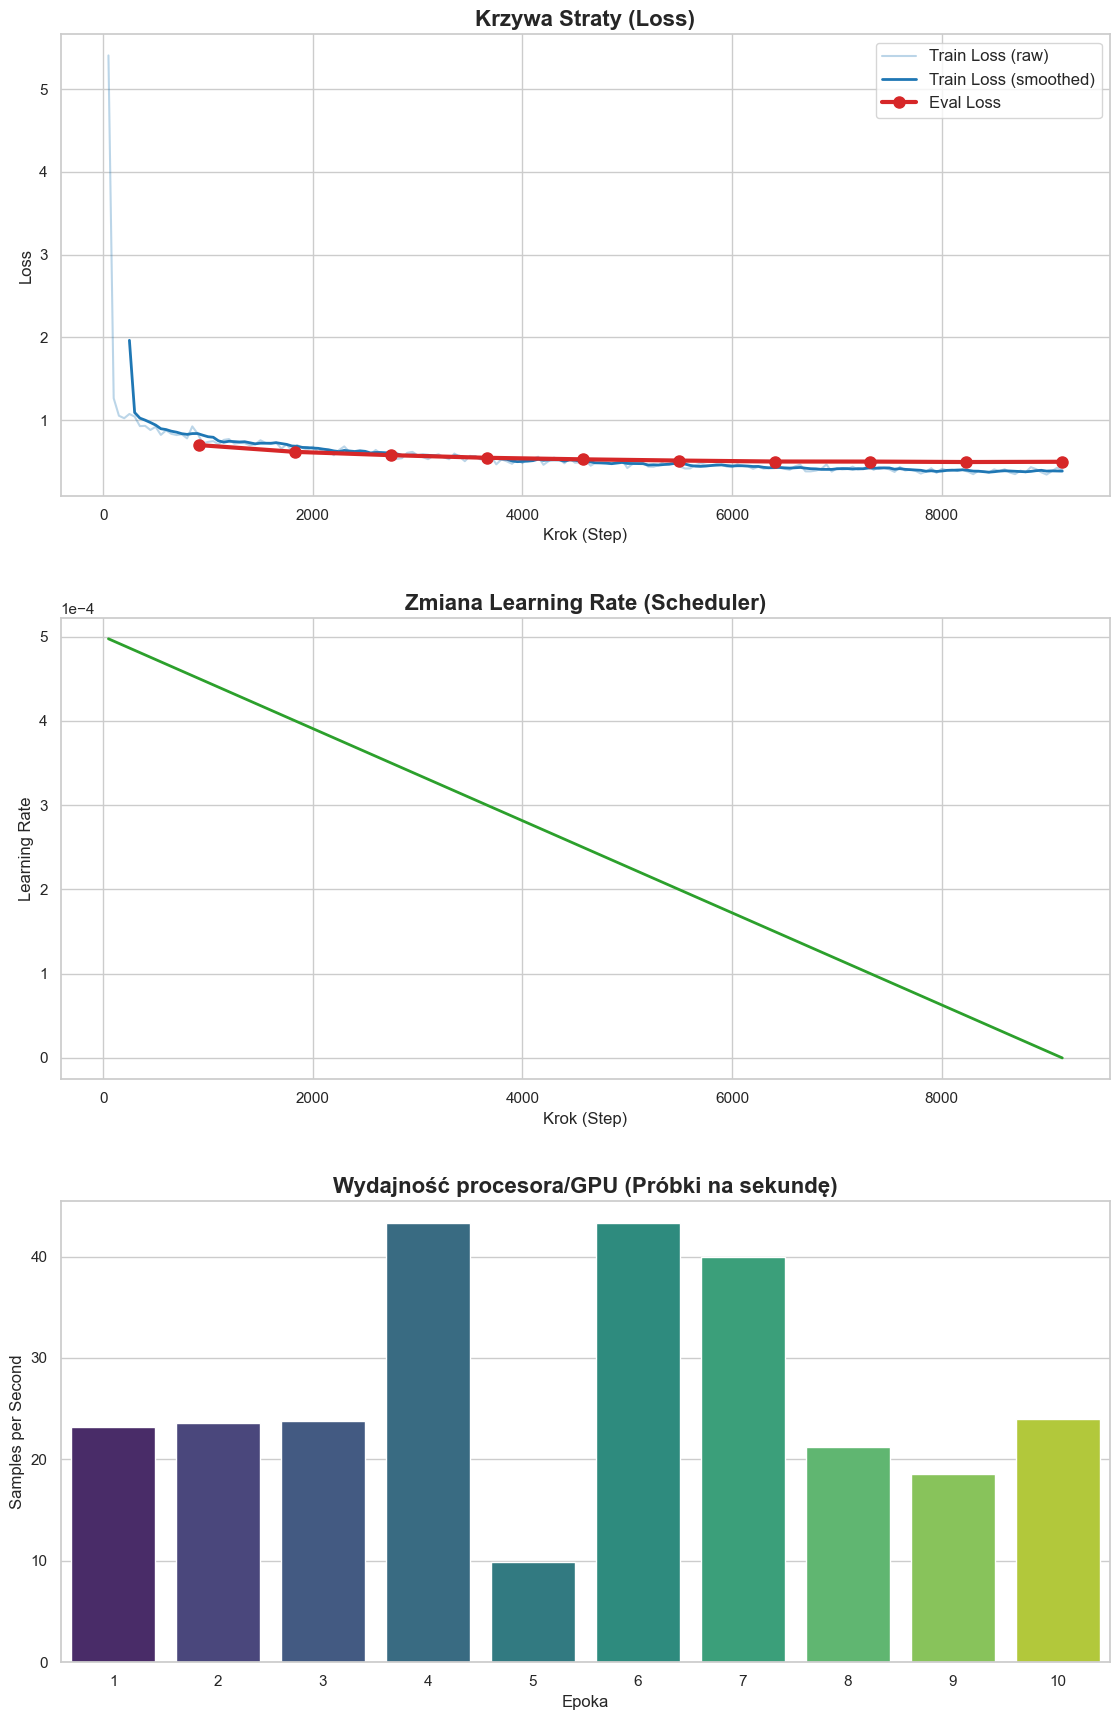


SZCZEGÓŁOWE WYNIKI EWALUACJI
 epoch  step  eval_loss  eval_runtime  eval_samples_per_second
   1.0   915   0.698937       35.1236                   23.175
   2.0  1830   0.617202       34.4665                   23.617
   3.0  2745   0.577280       34.1537                   23.833
   4.0  3660   0.545364       18.8015                   43.294
   5.0  4575   0.526966       82.4268                    9.875
   6.0  5490   0.512095       18.8094                   43.276
   7.0  6405   0.500422       20.3806                   39.940
   8.0  7320   0.499637       38.3302                   21.236
   9.0  8235   0.494340       43.7664                   18.599
  10.0  9150   0.497277       33.9088                   24.006


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Pobranie danych z historii trenera
history = trainer.state.log_history
df = pd.DataFrame(history)

# Rozdzielenie logów treningowych i ewaluacyjnych
train_df = df[df['loss'].notna()].copy()
eval_df = df[df['eval_loss'].notna()].copy()

# Konfiguracja stylu i rozmiaru - wysokość ustawiona na 18 cali dla 3 wykresów
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# --- WYKRES 1: STRATA (LOSS) ---
# Wyświetlamy surowe dane (lekka linia) i średnią kroczącą (wyraźna linia) dla lepszej czytelności
axes[0].plot(train_df['step'], train_df['loss'], label='Train Loss (raw)', color='#1f77b4', alpha=0.3)
axes[0].plot(train_df['step'], train_df['loss'].rolling(window=5).mean(), label='Train Loss (smoothed)', color='#1f77b4', linewidth=2)

if not eval_df.empty:
    axes[0].plot(eval_df['step'], eval_df['eval_loss'], label='Eval Loss', color='#d62728', marker='o', markersize=8, linewidth=3)

axes[0].set_title('Krzywa Straty (Loss)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Krok (Step)', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=12)

# --- WYKRES 2: LEARNING RATE ---
axes[1].plot(train_df['step'], train_df['learning_rate'], color='#2ca02c', linewidth=2)
axes[1].set_title('Zmiana Learning Rate (Scheduler)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Krok (Step)', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Notacja naukowa dla małych wartości

# --- WYKRES 3: WYDAJNOŚĆ (SAMPLES PER SECOND) ---
if not eval_df.empty:
    # Używamy barplotu dla wydajności na epokę
    sns.barplot(x=eval_df['epoch'].astype(float).astype(int), y=eval_df['eval_samples_per_second'], ax=axes[2], palette='viridis')
    axes[2].set_title('Wydajność procesora/GPU (Próbki na sekundę)', fontsize=16, fontweight='bold')
    axes[2].set_xlabel('Epoka', fontsize=12)
    axes[2].set_ylabel('Samples per Second', fontsize=12)
else:
    axes[2].text(0.5, 0.5, 'Brak danych o wydajności ewaluacji', ha='center', fontsize=14)

# Automatyczne dopasowanie marginesów, żeby napisy na siebie nie nachodziły
plt.tight_layout(pad=3.0)
plt.show()

# Wyświetlenie tabeli z kluczowymi metrykami pod wykresami
if not eval_df.empty:
    print("\n" + "="*50)
    print("SZCZEGÓŁOWE WYNIKI EWALUACJI")
    print("="*50)
    print(eval_df[['epoch', 'step', 'eval_loss', 'eval_runtime', 'eval_samples_per_second']].to_string(index=False))